In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt
from itertools import product
from torch import tensor
import pickle

In [2]:
from kfac.preconditioner import KFACPreconditioner

c:\programdata\miniconda3\lib\site-packages\kfac\distributed.py:17: UserWarning: NVIDIA Apex is not installed or was not installed with --cpp_ext. Falling back to PyTorch flatten and unflatten.
  warnings.warn(


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
MNIST_train = torchvision.datasets.MNIST('./', train=True)
MNIST_test = torchvision.datasets.MNIST('./', train=False)
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [5]:
X_val = X_train[-5000:]
y_val = y_train[-5000:]

X_train = X_train[:-5000]
y_train = y_train[:-5000]

In [5]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [7]:
resume = True

if resume: 
    with open('kfc_results.pkl', 'rb') as f:
        arr = pickle.load(f)
    test_accuracy_history_kfc = arr["acc"]
    test_history_kfc = arr["loss"]
else:
    test_accuracy_history_kfc, test_loss_history_kfc = {}, {}

In [9]:
for learning_rate, weight_decay in product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_kfc:
        print("Already computed, ignoring")
        continue
    
    lenet5 = LeNet5()
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(lenet5.parameters(), lr=learning_rate, weight_decay=weight_decay)
    preconditioner = KFACPreconditioner(lenet5)
    
    batch_size = 100
    test_loss_history_kfc[key] = list()
    test_accuracy_history_kfc[key] = list()

    for epoch in range(20):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
        
            batch_indexes = order[start_index:start_index+batch_size]
        
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = lenet5.forward(X_batch) 
        
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            
            preconditioner.step()
            
            optimizer.step()
        
        test_preds = lenet5.forward(X_val)
        test_loss_history_kfc[key].append(loss(test_preds, y_val).data)
    
        accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data
        test_accuracy_history_kfc[key].append(accuracy)
    
    print(test_accuracy_history_kfc[(learning_rate, weight_decay)])
    with open('kfc_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


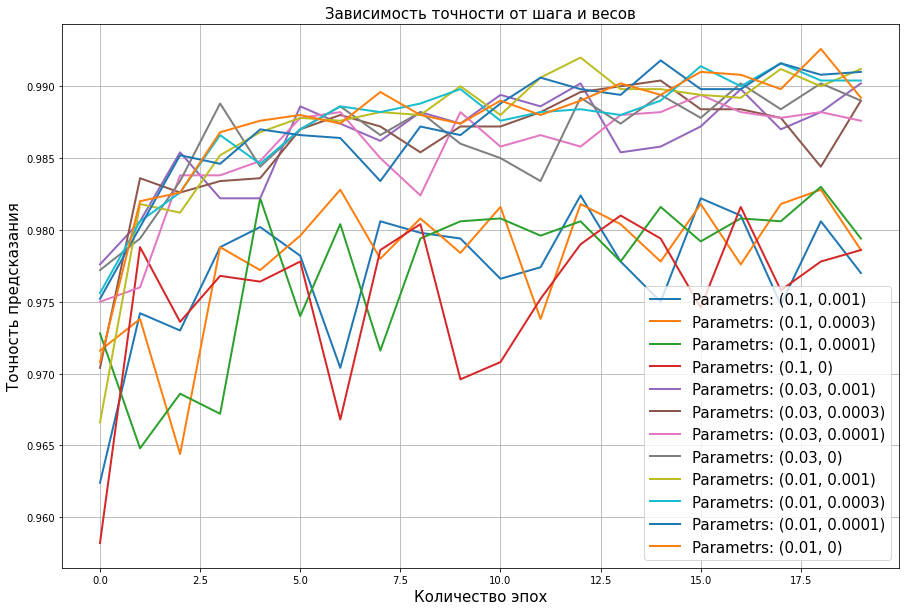

In [10]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for param, accuracy in test_accuracy_history_kfc.items():
    plt.plot(accuracy, label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

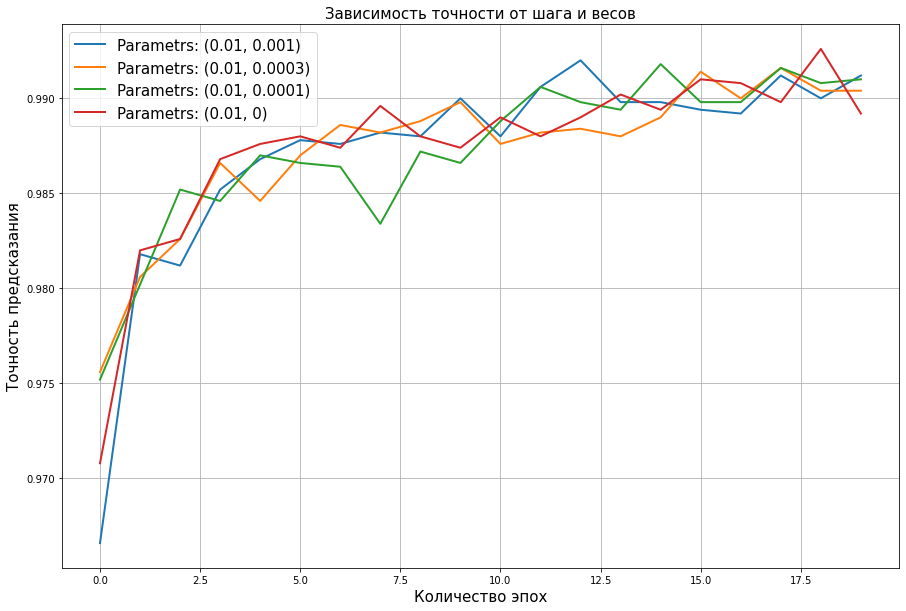

In [12]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for  param in product([0.01], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(test_accuracy_history_kfc[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

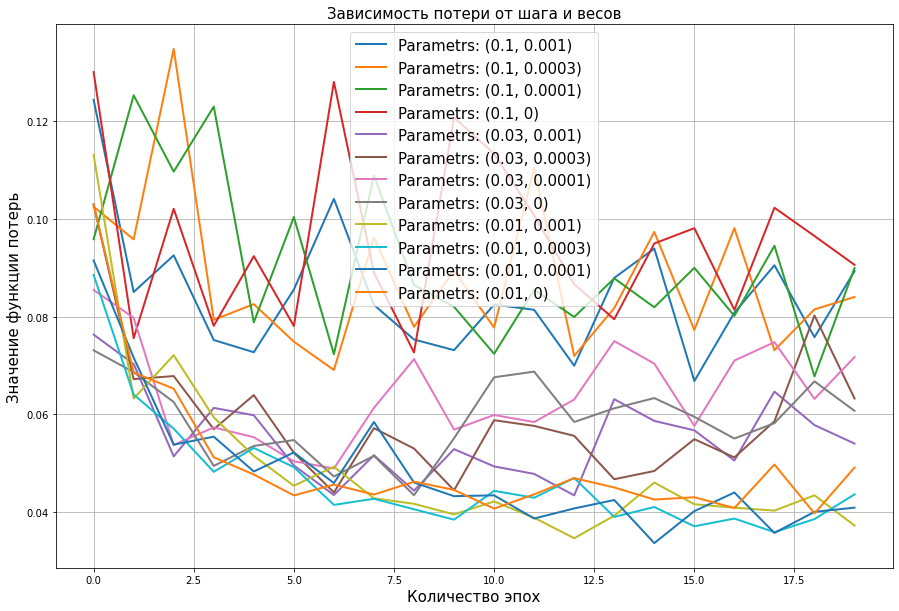

In [13]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
for param, loss in test_loss_history_kfc.items():
    plt.plot(loss, label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

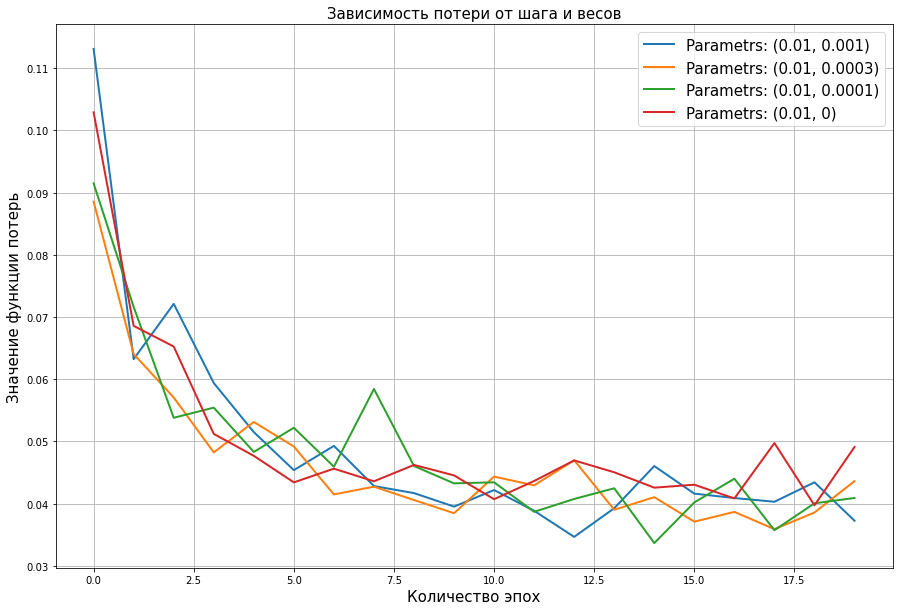

In [14]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
for  param in product([0.01], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(test_loss_history_kfc[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

In [15]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [6]:
lenet5 = LeNet5()
loss = torch.nn.CrossEntropyLoss()
    
optimizer = torch.optim.SGD(lenet5.parameters(), lr=0.01, weight_decay=0.0003)
preconditioner = KFACPreconditioner(lenet5)
    
batch_size = 100
test_loss_history_kfc = list()
test_accuracy_history_kfc = list()

for epoch in range(20):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
            
        preconditioner.step()
            
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history_kfc.append(loss(test_preds, y_test).data)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_kfc.append(accuracy)

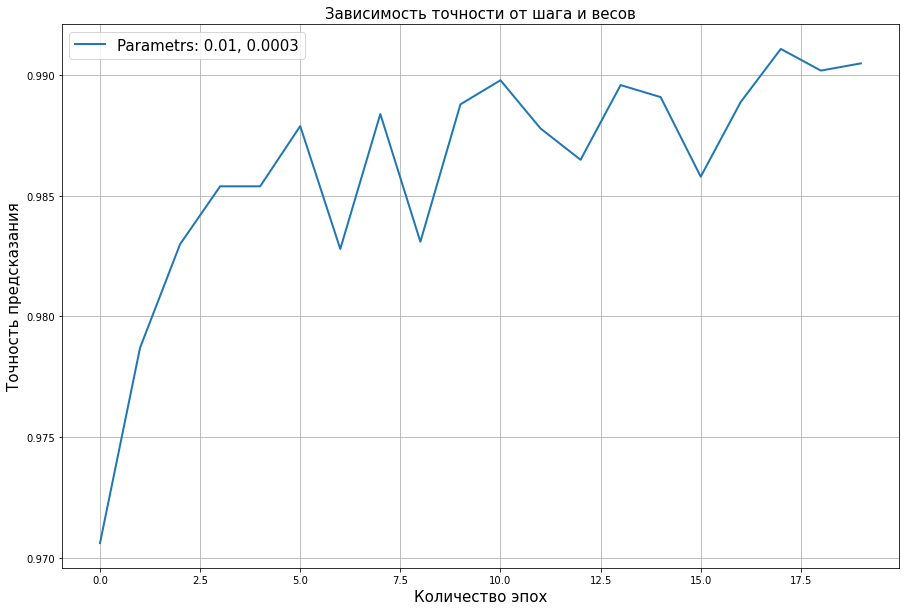

In [7]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
plt.plot(test_accuracy_history_kfc, label = "Parametrs: 0.01, 0.0003", linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

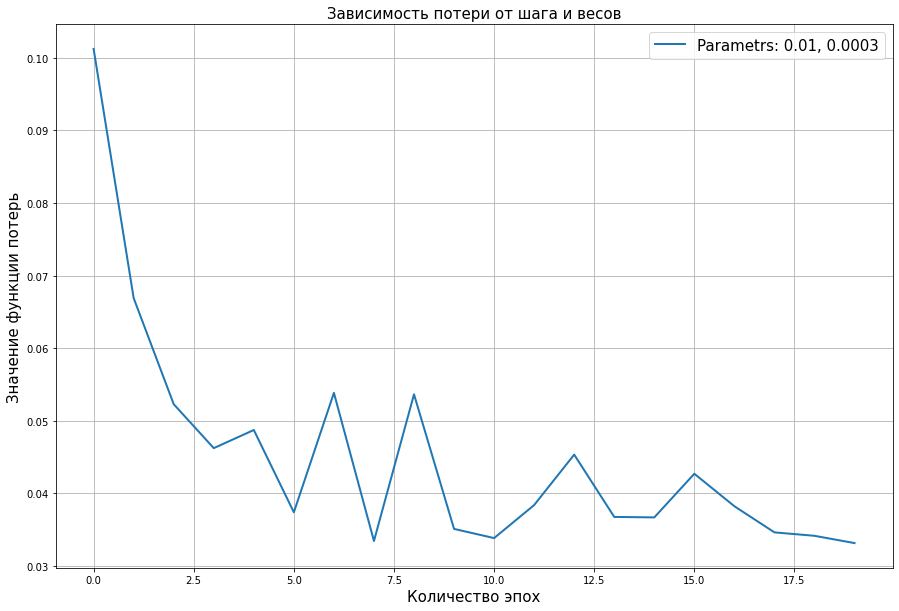

In [8]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
plt.plot( test_loss_history_kfc, label = "Parametrs: 0.01, 0.0003", linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

In [9]:
with open('results.pkl', 'wb') as f:
        pickle.dump({"kfc_acc": test_accuracy_history_kfc, "kfc_loss": test_loss_history_kfc}, f)

In [10]:
with open('kfc_results.pkl', 'rb') as f:
        arr = pickle.load(f)